<a href="https://colab.research.google.com/github/karyateguh/Sentiment_Analysis_iPusnas_apps/blob/master/analisis_sentimen_ipusnas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import modul

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


Load dataset

In [ ]:
import csv

df = pd.read_csv('https://drive.google.com/uc?id=1pg5BmnujnG-AYgZwV-JoQyMMvPMtzUHJ')
df.to_csv('ulasan_ipusnas.csv', index=False)
df = pd.DataFrame(df)

In [ ]:
df.drop(columns=['reviewId', 'userName', 'userImage', 'score', 'thumbsUpCount', 'reviewCreatedVersion', 'at', 'repliedAt', 'appVersion'], inplace=True)

In [ ]:
df = df.dropna()
df.to_csv('ulasan_ipusnas.csv', index=False)
df

,content,replyContent
0,Hari ini kok gak bisa dibuka aplikasinya?,Hallo Firdaus! Kami mohon maaf atas kendala da...
1,vertifikasi kgk muncul muncul,Hallo Senn! Kami mohon maaf atas ketidaknyaman...
2,"Susah taiiii, banyak errornyaa",Hallo Rizky! Kami mohon maaf atas kendala dan ...
3,"Ayolah pemerintah lebih urus ni aplikasi, ipus...",Hallo Orang! Kami mohon maaf atas ketidaknyama...
4,Sering tidak bisa dibuka,Hallo Chan! Kami mohon maaf atas kendala dan k...
...,...,...
13740,Sangat bermanfaat!,"Halo Stella, terimakasih atas review yang kamu..."
13741,coba dulu yaa,"Halo Bimo, terimakasih atas rating yang kamu b..."
13742,dikasih 5 bintang 👍,"Halo Mujiono, terimakasih atas rating yang kam..."
13743,Sangat membantu,"Terimakasih atas review yang kamu berikan, sem..."


Data Cleaning

In [ ]:
import nltk
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize, sent_tokenize

def casefoldingText(text):
    text = text.lower()
    return text

def remove_numbers(text):
    text_without_numbers = re.sub(r'\d+', '', text)
    return text_without_numbers

def remove_punctuation(text):
    text_without_punctuation = text.translate(str.maketrans('', '', string.punctuation))
    return text_without_punctuation

def remove_unwanted_characters(text):
    pattern = re.compile(r'[^a-zA-Z0-9\s-]')
    return pattern.sub('', text)

slangwords= {

    "disini": 'di sini', "disana": "di sana", "disiniii": "di sini", "dimana": "di mana", "kesana": "ke sana", "kesini": "ke sini", "keiniii": "ke ini", "kedepan": "ke depan", "kedepannya": "ke depannya", "yg": "yang", "dll": "dan lain-lain", "app": "aplikasi", "apknya": "aplikasinya", "apk": "aplikasi", "gk": "nggak", "antri": "antre", "antrian": "antrean", "sy": "saya", "tp": "tapi", "bsa": "bisa", "krna": "karena", "krn": "karena", "smg": "semoga", "hp": "ponsel", "fb": "facebook", "ig": "instagram", "ignya": "instagramnya", "tpi": "tapi", "terimakasih": "terima kasih", "handphone": "ponsel", "ttp": "tetap", "gabisa": "tidak bisa", "sm": "sama", "udh": "sudah", "copyan": "salinan", "ngak": "nggak", "y": "ya", "yaaa": "ya", "yaa": "ya", "trimakasih": "terima kasih", "trims": "terima kasih", "sdh": "sudah", "ny": "", "knp": "kenapa", "knpnya": "kenapa", "ganiat": "nggak niat", "dgn": "dengan", "bugnya": "bug", "klo": "kalau", "gaenak": "nggak enak", "gaenaknya": "nggak enaknya", "dr": "dari", "ngebug": "bug", "ad": "ada", "sya": "saya", "ngga": "nggak", "sngt": "sangat", "smkin": "semakin", "dg": "dengan", "bs": "bisa", "bgt": "banget", "bgtnya": "bangetnya", "jgn": "jangan", "nga": 'nggak', "dak": "tidak", "org": "orang", "kgk": "tidak", "taiiii": "tahi", "listannya": "daftarnya", "blm": "belum", "nggk": "nggak", "gmn": "bagaimana", "ga": "nggak", "gapapa": "nggak apa", "nya": "", "erorpas": "eror pas", "ngantrinya": "antrenya", "ngantri": "antre", "nge": "", "klau": "kalau", "gbisa": "nggak bisa", "pdhl": "padahal", "gw": "gue", "utk": "untuk", "trlalu": "terlalu", "jd": "jadi", "mls": "malas", "mw": "mau", "hnya": "hanya", "pke": "pakai", "sllu": "selalu", "apps": "aplikasi", "ferforma": "performa", "sukaaaaaaaaa": "suka", "sukaaa": "suka", "sukaaaa": "suka", "mao": "mau", "lom": "belum", "error": "eror", "errornya": "erornya", "ilang":"hilang", "install":"unduh", "upload": "unggah", "trs": "terus", "banyakkkkk": "banyak", "sebenernya": "sebenarnya", "tapiii": "tapi", "aplikasinua": 'aplikasinya', "inj": "ini", "lgi": "lagi", "cba": "coba", "makasih": "terima kasih", "makasihh": "terima kasih", "dlm": "dalam", "nya": "", "tks": "terima kasih", "g bisa": "nggak bisa", "trimaksih": "terima kasih", "error": "eror", "aplikasinua": "aplikasinya", "nnya": "tanya", "emng": "emang", "gtu": "gitu", "jga": "juga", "napa": "kenapa", "tlg": "tolong", "tlgnya": "tolongnya"
}


def replace_slangwords(text):
    words = text.split()
    replaced_words = [slangwords.get(word, word) for word in words]
    return ' '.join(replaced_words)

def remove_emoticons(text):
    emoticon_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"  # emoticons
                                  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                  u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                  u"\U00002702-\U000027B0"
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)
    return emoticon_pattern.sub(r'', text)

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    words = text.split()
    lemmatized_words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(lemmatized_words)

def stopword_removal(text):
    stop_words = set(stopwords.words('indonesian'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df = pd.read_csv('ulasan_ipusnas.csv')

df['content'] = df['content'].apply(casefoldingText)
df['content'] = df['content'].apply(remove_numbers)
df['content'] = df['content'].apply(remove_punctuation)
df['content'] = df['content'].apply(remove_unwanted_characters)
df['content'] = df['content'].apply(replace_slangwords)
df['content'] = df['content'].apply(lemmatization)
df['content'] = df['content'].apply(remove_emoticons)



df = df[df['content'].str.strip() != '']
df = df[df['content'].str.strip() != 'nan']
df = df[df['replyContent'].str.strip() != '']
df = df[df['replyContent'].str.strip() != 'nan']
df.to_csv('ulasan_ipusnas.csv', index=False)
df

,content,replyContent
0,hari ini kok gak bisa dibuka aplikasinya,Hallo Firdaus! Kami mohon maaf atas kendala da...
1,vertifikasi tidak muncul muncul,Hallo Senn! Kami mohon maaf atas ketidaknyaman...
2,susah tahi banyak errornyaa,Hallo Rizky! Kami mohon maaf atas kendala dan ...
3,ayolah pemerintah lebih urus ni aplikasi ipusn...,Hallo Orang! Kami mohon maaf atas ketidaknyama...
4,sering tidak bisa dibuka,Hallo Chan! Kami mohon maaf atas kendala dan k...
...,...,...
13418,sangat bermanfaat,"Halo Stella, terimakasih atas review yang kamu..."
13419,coba dulu ya,"Halo Bimo, terimakasih atas rating yang kamu b..."
13420,dikasih bintang,"Halo Mujiono, terimakasih atas rating yang kam..."
13421,sangat membantu,"Terimakasih atas review yang kamu berikan, sem..."


Pelabelan

In [ ]:
tanggapan_negatif = [
    "mohon maaf"
    "ketidaknyamanannya",
    "kendala",
    "ketidaknyamanan"
]


tanggapan_positif = [
    "bintang 5",
    "salam membaca",
    "semangat membaca",
    "sahabat setia",
    "sahabat setiamu",
    "teman terbaik",
    "teman terbaikmu",
    "rating yang kamu berikan"
]

# Fungsi untuk melabeli teks berdasarkan tanggapan
def label_tanggapan(text):
    text = text.lower()
    for tanggapan in tanggapan_negatif:
        if tanggapan in text:
            return 'negatif'

    for tanggapan in tanggapan_positif:
        if tanggapan in text:
            return 'positif'
    return 'netral'

# Terapkan fungsi ke kolom 'content'
df['sentiment'] = df['replyContent'].apply(label_tanggapan)


In [ ]:
df.drop(columns=['replyContent'], inplace=True)
df.to_csv('ulasan_ipusnas.csv', index=False)
df

,content,sentiment
0,hari ini kok gak bisa dibuka aplikasinya,negatif
1,vertifikasi tidak muncul muncul,negatif
2,susah tahi banyak errornyaa,negatif
3,ayolah pemerintah lebih urus ni aplikasi ipusn...,negatif
4,sering tidak bisa dibuka,negatif
...,...,...
13418,sangat bermanfaat,positif
13419,coba dulu ya,positif
13420,dikasih bintang,positif
13421,sangat membantu,positif


Text(0.5, 1.0, 'Persentase Masing-Masing Sentimen')

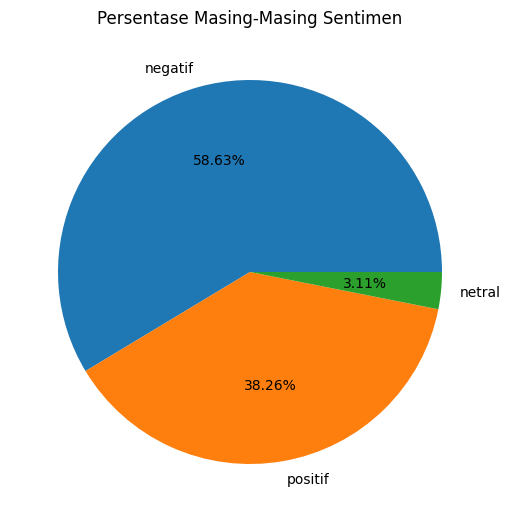

In [ ]:
diagram = df['sentiment'].value_counts().rename_axis('nilai_sentimen').reset_index(name='jumlah')
label = diagram.nilai_sentimen
nilai = diagram.jumlah

import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.axis = ('equal')


ax.pie(nilai, labels = label, autopct='%1.2f%%' )
ax.set_title("Persentase Masing-Masing Sentimen")


Membagi data

In [ ]:
# Memisahkan fitur (teks) dan label
texts = df['content'].values
labels = df['sentiment'].values

In [ ]:
# Mengonversi label ke dalam bentuk numerik
label_map = {'positif': 0, 'negatif': 1, 'netral': 2}
labels = np.array([label_map[label] for label in labels])

In [ ]:
print(texts)
print(labels)

['hari ini kok gak bisa dibuka aplikasinya'
 'vertifikasi tidak muncul muncul' 'susah tahi banyak errornyaa' ...
 'dikasih bintang' 'sangat membantu'
 'keren banget idenya membuat aplikasi ini saya sangat suka terima kasih']
[1 1 1 ... 0 0 0]


Ekstraksi fitur

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer


vectorizer = TfidfVectorizer()
X_tfidf = vectorizer.fit_transform(texts)


X_train, X_test, y_train, y_test = train_test_split(X_tfidf, labels, test_size=0.2, random_state=42)

In [ ]:
# Mengonversi teks menjadi sequences menggunakan Tokenizer
tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
tokenizer.fit_on_texts(texts)
word_index = tokenizer.word_index

sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post')

# Membagi dataset menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

Membangun Model

In [ ]:
model = Sequential([
    Embedding(input_dim=10000, output_dim=64),
    Bidirectional(LSTM(64, return_sequences=True)),
    BatchNormalization(),
    Dropout(0.5),
    Bidirectional(LSTM(64)),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dense(3, activation='softmax')
])

In [ ]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Melatih model

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), callbacks=[early_stopping])

Epoch 1/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 192s 516ms/step - accuracy: 0.7799 - loss: 0.6114 - val_accuracy: 0.8854 - val_loss: 0.4590
Epoch 2/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 219s 566ms/step - accuracy: 0.8979 - loss: 0.3497 - val_accuracy: 0.8738 - val_loss: 0.3829
Epoch 3/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 185s 514ms/step - accuracy: 0.9102 - loss: 0.2957 - val_accuracy: 0.8858 - val_loss: 0.3498
Epoch 4/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 201s 510ms/step - accuracy: 0.9227 - loss: 0.2541 - val_accuracy: 0.8573 - val_loss: 0.4052
Epoch 5/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 202s 508ms/step - accuracy: 0.9254 - loss: 0.2286 - val_accuracy: 0.8831 - val_loss: 0.3859
Epoch 6/10
334/334 ━━━━━━━━━━━━━━━━━━━━ 196s 491ms/step - accuracy: 0.9274 - loss: 0.2134 - val_accuracy: 0.8742 - val_loss: 0.4054


In [ ]:
train_loss, train_acc = model.evaluate(X_train, y_train)
print('Train Loss:', train_loss)
print('Train Accuracy:', train_acc)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

334/334 ━━━━━━━━━━━━━━━━━━━━ 45s 135ms/step - accuracy: 0.9202 - loss: 0.2386
Train Loss: 0.23932284116744995
Train Accuracy: 0.9222627878189087
84/84 ━━━━━━━━━━━━━━━━━━━━ 10s 120ms/step - accuracy: 0.8855 - loss: 0.3516
Test Loss: 0.349801629781723
Test Accuracy: 0.8857678174972534


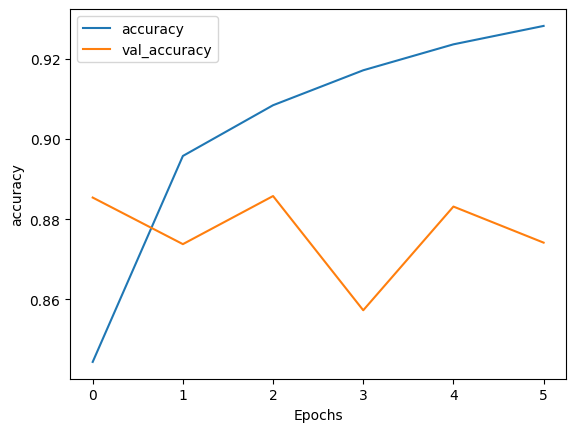

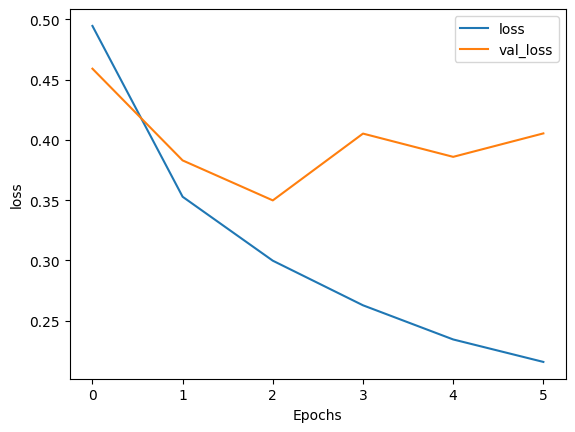

In [ ]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric])
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

Prediksi

In [ ]:
def predict_sentiment(text):
    # Preprocess the input text
    text = text.lower()
    sequence = tokenizer.texts_to_sequences([text])
    padded_sequence = pad_sequences(sequence, padding='post', maxlen=X_train.shape[1])

    # Make prediction
    prediction = model.predict(padded_sequence)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Map the predicted label to sentiment
    label_map = {0: 'positif', 1: 'negatif', 2: 'netral'}
    return label_map[predicted_label]


input_text = "Saya sangat senang dengan aplikasi ini, sangat berguna!"
print(f"Teks: {input_text}")
print(f"Prediksi Sentimen: {predict_sentiment(input_text)}")

Teks: Saya sangat senang dengan aplikasi ini, sangat berguna!
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 668ms/step
Prediksi Sentimen: positif
